In [ ]:
# How many stacked exposures are required for a detection as a function of distance? 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Imports and setup

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.io import fits
from astropy.table import Table, QTable
from astroduet.background import background_pixel_rate
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence
from astroduet.image_utils import construct_image, estimate_background, find, ap_phot
from astroduet.diff_image import py_zogy, calculate_diff_image
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image

# Telescope parameters
duet = Telescope()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True)
psf_fwhm_pix = duet.psf_fwhm / duet.pixel

# Simulation parameters
start_times = np.array([1800,3000,4200]) * u.s   # 30,50,70 minutes in seconds
distances = np.array([100,150,200,250,300]) * u.Mpc
frame = np.array([30,30])
exposure = 300 * u.s
psf_array = duet.psf_model(x_size=5,y_size=5).array

# 6 is oversampling used in construct_image() 
# - to-do: update sim_galaxy to accept r_eff in arcsec rather than pixels, so we can be agnostic about oversampling
oversample = 6
r_eff_init = 16.5/(duet.pixel.value/oversample) # Average r_eff for spiral galaxy at 100 Mpc, in pixels


# Suppress daophot warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

In [7]:
# Now that we have the files, loop through them, adding them until we reach a detection threshold of 5 sigma
debugdir = os.path.join(os.getcwd(), 'debug_imgs')

results = Table(names=('distance', 'pos', 'start_time', 'model', 'num_exp'), 
                dtype=('i2', 'i2', 'f2', 'S5', 'i2'))

# Loop through distances
distances = np.array([100,150,200,250,300]) * u.Mpc
for run in range(10):
    print(run)
    for distance in distances:
        r_eff = r_eff_init * ((100*u.Mpc)**2 / distance**2) # r_eff for spiral galaxy at distance, in pixels
        r_eff = r_eff.value

        # Loop through three different source positions: r_eff*2, r_eff, r_eff/2, called 1, 2, 3
        for x_0, pos in zip([r_eff*2, r_eff, r_eff/2], [1,2,3]):            

            # Galaxy parameters
            gal_params = {'magnitude': 24, 'r_eff': r_eff, 'n': 1, 'theta': 0, 'ellip': 0.5, 'x_0': x_0, 'y_0': 0}

            # Generate combined reference image for this galaxy/source setup
            nexp = 5
            ref_image1 = construct_image(frame, exposure, duet=duet, band=duet.bandpass1,
                                         gal_type='custom', gal_params=gal_params, sky_rate=bgd_band1, n_exp=nexp)
            ref_image2 = construct_image(frame, exposure, duet=duet, band=duet.bandpass2,
                                         gal_type='custom', gal_params=gal_params, sky_rate=bgd_band2, n_exp=nexp)
            total_ref_rate = (ref_image1 + ref_image2) / (exposure * nexp)
            ref_bkg, ref_bkg_rms_median = estimate_background(total_ref_rate, method='1D', sigma=2)
            ref_bkgsub = total_ref_rate - ref_bkg

            # Loop through different start times
            for start_time in start_times:
                # Loop through different models
                for mod in ['shock','blukn']:

                    # Grab the lightcurve files we need 
                    name = '{}_{}Mpc_pos{}_{}s'.format(mod,np.int(distance.value),pos,np.int(start_time.value))
                    table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')

                    # Loop through images, summing until we get a detection
                    img_sum = np.zeros(frame) * u.ph / u.s
                    for row in table:
                        # Add both bands and add them to total summed image
                        img_sum += (row['imgs_D1'] + row['imgs_D2']) * u.ph / u.s

                        # Convert to average rate
                        num_exp = row.index+1
                        img_rate = img_sum / (num_exp)

                        # Estimate background
                        img_bkg, img_bkg_rms_median = estimate_background(img_rate, method='1D', sigma=2)
                        img_bkgsub = img_rate - img_bkg

                        # Make difference image
                        diff_image = calculate_diff_image(img_rate, img_bkgsub, total_ref_rate, ref_bkgsub)

                        # Run find - do we detect an image to 5 sigma?
                        star_tbl, bkg_image, threshold = find(diff_image,psf_fwhm_pix.value,method='peaks', background='1D')

                        if star_tbl[(star_tbl['x'] == (frame[0]//2)) & (star_tbl['y'] == (frame[1]//2))]: 
                            result, apertures, annulus_apertures = ap_phot(diff_image,star_tbl[(star_tbl['x'] == (frame[0]//2)) & (star_tbl['y'] == (frame[1]//2))],duet.read_noise,exposure)

                            # Sanity check, is this close to the rate that you put in:                        
                            found_rate = result['aperture_sum'].value
                            true_rate = duet.fluence_to_rate(row['fluence_D1']).value + \
                                        duet.fluence_to_rate(row['fluence_D2']).value
                            frac_diff = abs(found_rate - true_rate) / true_rate
                            if frac_diff > 0.8:
     #                           print(found_rate, true_rate, frac_diff)
                                print(mod, start_time.value, pos,distance,frac_diff, 'False Positive')
                            else:
                                # Source successfully found! End loop
                                results.add_row((distance, pos, start_time, mod, num_exp))
                                break
                        if num_exp > 50:
                            print(mod, start_time.value, pos,distance, 'Too many exposures')
                            results.add_row((distance, pos, start_time, mod, -1))
                            break


    #                 # Store the number of exposures that were required to detect the source in this setup


0
blukn 1800.0 3 100.0 Mpc [0.83620035] False Positive
blukn 4200.0 3 100.0 Mpc [0.95158524] False Positive
blukn 1800.0 1 200.0 Mpc [0.96392823] False Positive
blukn 1800.0 1 200.0 Mpc [0.95981316] False Positive
blukn 1800.0 1 200.0 Mpc [0.89406345] False Positive
blukn 1800.0 1 200.0 Mpc [0.83906737] False Positive
blukn 1800.0 1 200.0 Mpc [0.83454399] False Positive
blukn 1800.0 1 200.0 Mpc [0.82244677] False Positive
blukn 1800.0 1 200.0 Mpc [0.80400909] False Positive
blukn 4200.0 1 200.0 Mpc [0.85551652] False Positive
blukn 4200.0 1 200.0 Mpc [0.82120437] False Positive
blukn 1800.0 3 200.0 Mpc [3.58655779] False Positive
blukn 1800.0 3 200.0 Mpc [1.75725974] False Positive
blukn 1800.0 3 200.0 Mpc [1.06694866] False Positive
1
blukn 1800.0 2 200.0 Mpc [1.60876365] False Positive
blukn 3000.0 1 300.0 Mpc Too many exposures
blukn 4200.0 1 300.0 Mpc Too many exposures
2
blukn 4200.0 3 100.0 Mpc [0.90204213] False Positive
blukn 1800.0 1 150.0 Mpc [0.94404693] False Positive
blukn

blukn 1800.0 2 200.0 Mpc [1.04401596] False Positive
blukn 1800.0 2 200.0 Mpc [0.90620418] False Positive
blukn 3000.0 2 200.0 Mpc [1.42765853] False Positive
blukn 1800.0 3 200.0 Mpc [2.58770764] False Positive
blukn 1800.0 1 300.0 Mpc Too many exposures
blukn 3000.0 1 300.0 Mpc Too many exposures
blukn 4200.0 1 300.0 Mpc Too many exposures
blukn 4200.0 3 300.0 Mpc [0.8382705] False Positive
blukn 4200.0 3 300.0 Mpc [0.82034061] False Positive


In [9]:
results.write('EMGW_point_sources', format='fits')

blukn 1 - 100 2
blukn 1 - 150 2
blukn 1 - 200 23
blukn 1 - 250 18
blukn 1 - 300 11
blukn 1 - 100 1
blukn 1 - 150 12
blukn 1 - 200 17
blukn 1 - 250 9
blukn 1 - 300 42
blukn 1 - 100 2
blukn 1 - 150 6
blukn 1 - 200 14
blukn 1 - 250 24
blukn 1 - 300 21
blukn 1 - 100 1
blukn 1 - 150 3
blukn 1 - 200 16
blukn 1 - 250 24
blukn 1 - 300 39
blukn 1 - 100 3
blukn 1 - 150 9
blukn 1 - 200 13
blukn 1 - 250 27
blukn 1 - 300 29
blukn 1 - 100 2
blukn 1 - 150 3
blukn 1 - 200 14
blukn 1 - 250 -1
blukn 1 - 300 36
blukn 1 - 100 2
blukn 1 - 150 3
blukn 1 - 200 19
blukn 1 - 250 24
blukn 1 - 300 30
blukn 1 - 100 2
blukn 1 - 150 3
blukn 1 - 200 13
blukn 1 - 250 27
blukn 1 - 300 22
blukn 1 - 100 2
blukn 1 - 150 3
blukn 1 - 200 13
blukn 1 - 250 16
blukn 1 - 300 21
blukn 1 - 100 2
blukn 1 - 150 3
blukn 1 - 200 13
blukn 1 - 250 15
blukn 1 - 300 -1
blukn 1 -- 100 1
blukn 1 -- 150 3
blukn 1 -- 200 10
blukn 1 -- 250 15
blukn 1 -- 300 3
blukn 1 -- 100 1
blukn 1 -- 150 13
blukn 1 -- 200 11
blukn 1 -- 250 4
blukn 1 -- 30

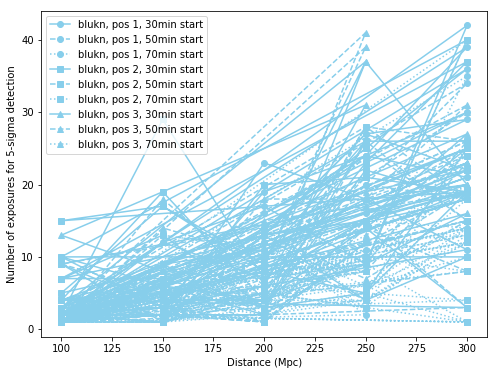

In [16]:
# Results plots - number of exposures vs distance for different models, start times, source positions
plt.figure(figsize=(8, 6))

# Loop through three different source positions
for mod, col in zip(['shock','blukn'],['coral','skyblue']):
    if mod is 'shock':
        continue
    # Loop through different models
    for pos,m in zip([1,2,3],['o','s','^']):

        # Loop through different start times
        for start_time, ls in zip(start_times,['-','--',':']):


            mask = (results['pos'] == pos) & \
                   (results['start_time'] == np.int(start_time.value)) & \
                   (results['model'] == mod)
            
            dist = results[mask]['distance']
            num = results[mask]['num_exp']
            
            for d, n in zip(dist, num):
                print(mod, pos,ls, d, n)

            mask = (results['pos'] == pos) & \
                (results['start_time'] == np.int(start_time.value)) & \
                (results['model'] == mod) & (results['num_exp'] > 0)

            dist = results[mask]['distance']
            num = results[mask]['num_exp']


            plt.plot(dist,num,marker=m,color=col,linestyle=ls,
                     label='{}, pos {}, {}min start'.format(mod,pos,np.int(start_time.to(u.min).value)))
plt.xlabel('Distance (Mpc)')
plt.ylabel('Number of exposures for 5-sigma detection')
plt.legend()



In [111]:
nexp= []
dev = []
minexp = []
maxnexp = []
for i, distance in enumerate(distances):
    print(distance.value)
    mask = (results['distance'] == np.int(distance.value)) & (results['num_exp'] > 0) & (results['model'] == 'blukn')
    mean_nexp = results[mask]['num_exp'].mean()
    min_nexp = results[mask]['num_exp'].min()
    max_nexp = results[mask]['num_exp'].max()
    
    std_nexp = results[mask]['num_exp'].std()
    nexp = np.append(nexp, mean_nexp)
    dev = np.append(dev, std_nexp)
    minnexp = np.append(minexp, min_nexp)
    maxnexp = np.append(maxnexp, max_nexp)
    print(min_nexp)

100.0
1
150.0
1
200.0
1
250.0
2
300.0
1


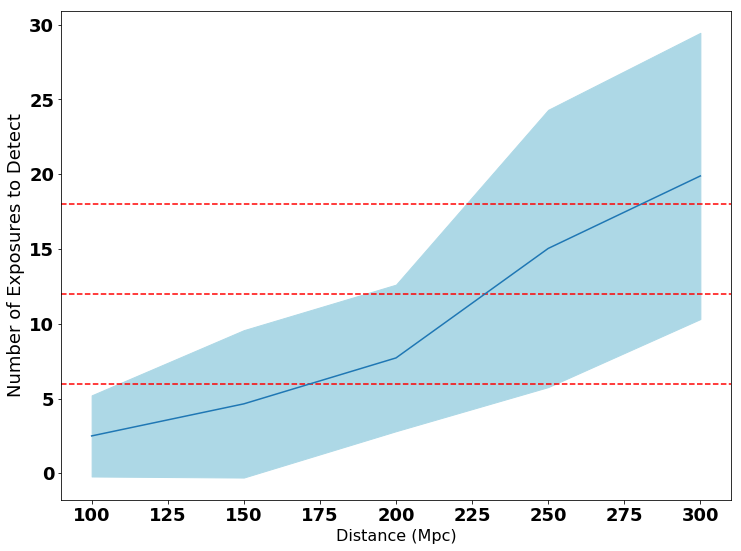

In [118]:

import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)
plt.figure(figsize=(12, 9))
plt.xlabel('Distance (Mpc)', fontsize=16)
plt.ylabel('Number of Exposures to Detect', fontsize=18)
plt.xticks(fontsize=18)
plt.fill_between(distances, nexp-dev,
                 nexp+dev, color='lightblue')
plt.axhline(y=6, color='r', linestyle='--')
plt.axhline(y=12, color='r', linestyle='--')
plt.axhline(y=18, color='r', linestyle='--')
plt.plot(distances, nexp)